# Predict park accessibility in NYC using Machine Learning

In this notebook, we work through how we can ingest the parquet file produced by our ETL pipeline into an ML algorithm for training a model to predict accessibility. We will go through the entire data science lifecyle -- 

data ingest --> data exploration --> data cleaning --> staging the training data --> machine learning.

Accessiblity here is defined as whether parks are categorized as Level 4 or not.  

For Machine learning, we will use two approaches -- 

1/ Train an XGBoost model to predict whether accessible parks are available based on individual tax returns and park data 

2/ Train a model using SageMaker Autopilot and compare the results. SageMaker Autopilot is a fully managed ML service that can train various machine learning models with different hyperparameters, and allow you to pick the best one. Here we will use the SageMaker Python SDK to make API calls to SageMaker Autopilot to train and deploy an ML model.

# Import Libraries and Data

Note that to import the data in parquet format into a pandas dataframe, we will need to install pyarrow library.

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, classification_report
from sklearn.model_selection import train_test_split
import io
import sagemaker.amazon.common as smac
import boto3
import re
from sagemaker import get_execution_role
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer, json_deserializer


In [4]:
# if needed, updated boto3
!pip install --upgrade pip
if boto3.__version__ != '1.10.33':
    !pip install boto3=='1.10.33'
else:
    pass


Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (19.3.1)


In [5]:
!pip install pyarrow

In [83]:
FILENAME = 'part-00000-588c7835-a113-419a-8cea-580b11e397e8-c000.snappy.parquet'
df = pd.read_parquet(FILENAME)
df.head()

,Accessible,Adaptive_Swing,Level,Playground_ID,School_ID,Status,lat,lon,num_of_returns,zipcode,...,num_of_head_of_household_returns,num_of_volunteer_prepared_returns_Num_of_volunteer_income_tax_assistance_prepared_returns,num_of_exemptions,Name,num_of_volunteer_prepared_returns_Num_of_tax_counseling_for_the_elderly_prepared_returns,Prop_ID,Location,num_of_volunteer_prepared_returns_Total,num_of_joint_returns,num_of_dependents
0,Y,N,4,B080-01,None,None,40.5753,-73.9722,10120.0,11224.0,...,2310.0,410.0,16270.0,Asser Levy Park,0.0,B080,"Boardwalk, Surf Ave., Sea Breeze Ave., Ocean P...",410.0,1380.0,5480.0
1,Y,N,4,B080-01,None,None,40.5753,-73.9722,4890.0,11224.0,...,1510.0,130.0,9100.0,Asser Levy Park,0.0,B080,"Boardwalk, Surf Ave., Sea Breeze Ave., Ocean P...",130.0,960.0,3260.0
2,Y,N,4,B080-01,None,None,40.5753,-73.9722,2350.0,11224.0,...,580.0,0.0,4320.0,Asser Levy Park,0.0,B080,"Boardwalk, Surf Ave., Sea Breeze Ave., Ocean P...",0.0,630.0,1350.0
3,Y,N,4,B080-01,None,None,40.5753,-73.9722,1280.0,11224.0,...,260.0,0.0,2490.0,Asser Levy Park,0.0,B080,"Boardwalk, Surf Ave., Sea Breeze Ave., Ocean P...",0.0,520.0,700.0
4,Y,N,4,B080-01,None,None,40.5753,-73.9722,1350.0,11224.0,...,180.0,0.0,3100.0,Asser Levy Park,0.0,B080,"Boardwalk, Surf Ave., Sea Breeze Ave., Ocean P...",0.0,810.0,950.0


In [133]:
df.Playground_ID.value_counts()

Q133        12
B111        12
B066        12
Q104-01     12
M041         6
Q162E        6
B332         6
X168         6
Q300-05      6
Q205A        6
X171         6
M113         6
B306         6
B121         6
X034-01      6
M058-06      6
Q123         6
M243         6
B164         6
Q426         6
X300         6
M200         6
M184         6
B135         6
M308         6
X194         6
X258         6
X116         6
R067         6
X038-01      6
            ..
Q163-21      1
Q099-15      1
X010-02      1
X010-05      1
Q020-02      1
M071-18      1
Q027         1
B057-04      1
Q015-05      1
Q001-01      1
X010-03      1
M399-01      1
Q458         1
Q008-01      1
Q300A-01     1
M283-01      1
Q300B        1
M010-176     1
X039-01      1
B058-01      1
X010-08      1
M010-202     1
M037-04      1
X030-99      1
Q008-02      1
B028-01      1
Q021-01      1
Q162G13      1
M140-01      1
M010-145     1
Name: Playground_ID, Length: 1016, dtype: int64

In [57]:
print("Shape of Dataset = {}".format(df.shape))

Shape of Dataset = (5423, 23)


In [58]:
list(df.columns)

['Accessible',
 'Adaptive_Swing',
 'Level',
 'Playground_ID',
 'School_ID',
 'Status',
 'lat',
 'lon',
 'num_of_returns',
 'zipcode',
 'num_of_single_returns',
 'size_of_adjusted_gross_income',
 'num_with_paid_preparers_signature',
 'num_of_head_of_household_returns',
 'num_of_volunteer_prepared_returns_Num_of_volunteer_income_tax_assistance_prepared_returns',
 'num_of_exemptions',
 'Name',
 'num_of_volunteer_prepared_returns_Num_of_tax_counseling_for_the_elderly_prepared_returns',
 'Prop_ID',
 'Location',
 'num_of_volunteer_prepared_returns_Total',
 'num_of_joint_returns',
 'num_of_dependents']

# Data Cleaning prior to Exploration

There are several data cleaning steps that need to be performed:

1) There isn't enough data to identify each playground Id separately but we can extract the Borough information as a categorical variable <br/>
2) We need to convert the AGI to ordinal values <br/>
3) We need to convert Accessible and Adaptible Swing to numeric values <br/>
4) We will drop the name and location columns <br/>
5) We will drop any columns on volunteer prepared taxes <br/>

In [84]:
df['Borough'] = [str(x)[0] for x in df.Playground_ID.values]
convert_cols = {'Accessible': {'Y': 1, 'N': 0},
                'Adaptive_Swing': {'Y': 1, 'N': 0}}#,
              # 'adjusted_gross_income': {'':0, '$1 under $25,000':1, '$25,000 under $50,000': 2, '$50,000 under $75,000':3, 
              #                          '$75,000 under $100,000':4, '$100,000 under $200,000':5, '$200,000 or more':6}}
df.replace(convert_cols, inplace = True)

In [85]:
COLSCONVERT = ['Adaptive_Swing', 'num_of_exemptions',
       'Accessible', 'num_of_dependents', 'num_of_returns',
       'num_of_joint_returns', 'num_of_head_of_household_returns',
       'num_of_single_returns']
indexlist = []
for col in COLSCONVERT:
    indexlist = indexlist + list(df.loc[df[col]=='**'].index)
df = df.drop(index= indexlist)
df[COLSCONVERT] = df[COLSCONVERT].apply(pd.to_numeric)
df.replace({'Level': {None:0, '1':0, '2':0, '3':0, '4':1}}, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [86]:
COLS_TO_DROP = ['lat', 'lon', 'Playground_ID', 'Name', 'Location', 'Prop_ID','num_of_volunteer_prepared_returns_Total',
                  'num_of_volunteer_prepared_returns_Num_of_volunteer_income_tax_assistance_prepared_returns',
                 'num_with_paid_preparers_signature','num_of_volunteer_prepared_returns_Num_of_tax_counseling_for_the_elderly_prepared_returns', 
                'zipcode','School_ID','Status']
df = df.drop(columns = COLS_TO_DROP)

In [87]:
# let's save this dataframe at this stage as a separate dataframe for AutoPilot
autodf = df

Mark everything with Level 4 as 1, and else 0. Why have we done this?

Look at the graph below. It shows that most playgrounds in NYC are classified as Level 4 playgrounds.  Level 4 means Accessible Playgrounds with Transfer Platforms and Ground Level Play Features; and thus represents the most sophisticated playgrounds.

We want to predict whether a given Playground ID in a given school district, given demographic information about the income levels of households in that zipcode is a Level 4 playground or not. 

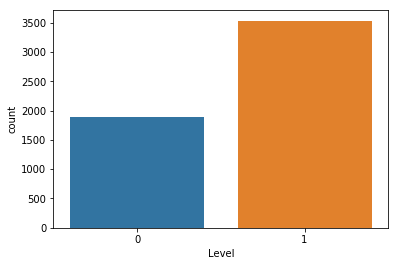

In [139]:
sns.countplot(df.Level)

In [63]:
print("Baseline Model accuracy = {}".format(len(df[df['Level']==1])/len(df)))

Baseline Model accuracy = 0.6511156186612576


In [64]:
df.dropna(inplace=True)
df.shape

(4590, 11)

# Data Exploration

Having converted the raw data into numerical format, we can explore the dataset and extract some meaningful information and look for any correlations in the data, which may be indicative of whether income is correlated to playground type

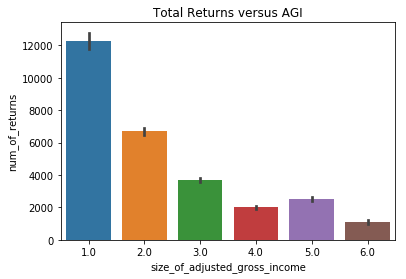

In [142]:
# Total returns versus AGI shows an overall trend that we need to normalize out. 
sns.barplot(x='size_of_adjusted_gross_income', y = 'num_of_returns', data = df)
plt.title("Total Returns versus AGI")
plt.show()

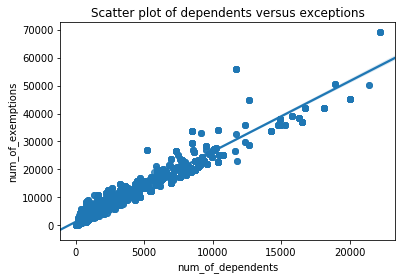

In [143]:
# Number of dependents versus number of exceptions
sns.regplot(x = 'num_of_dependents', y = 'num_of_exemptions', data = df)
plt.title("Scatter plot of dependents versus exceptions")
plt.show()

In [67]:
# Introduce new columns which are the normalized number of joint, head of household and single returns
COLS_TO_NORMALIZE = ['num_of_joint_returns', 'num_of_head_of_household_returns',
       'num_of_single_returns']
for col in COLS_TO_NORMALIZE:
    df['normalized_'+ col] = df[col]/df['num_of_returns']

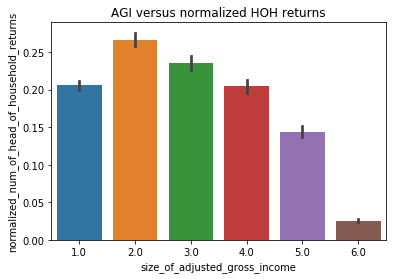

In [145]:
sns.barplot(x='size_of_adjusted_gross_income', y = 'normalized_num_of_head_of_household_returns', data = df)
plt.title("AGI versus normalized HOH returns")
plt.show()

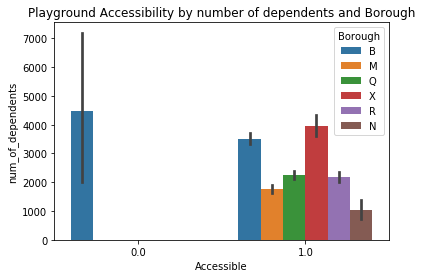

In [146]:
sns.barplot(x='Accessible', y = 'num_of_dependents', hue = 'Borough', data = df)
plt.title("Playground Accessibility by number of dependents and Borough")
plt.show()

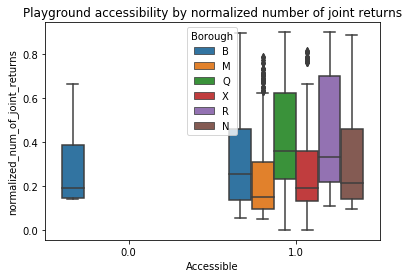

In [147]:
sns.boxplot(x = 'Accessible', y = 'normalized_num_of_joint_returns', hue = 'Borough', data = df)
plt.title("Playground accessibility by normalized number of joint returns")
plt.show()

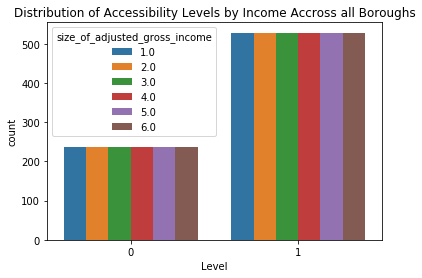

In [148]:
# Not much correlation between adjusted gross income level and number of available playgrounds. Certain zip codes simply
# dont have any filers in the high income categories. 
sns.countplot(x = 'Level' , hue = 'size_of_adjusted_gross_income', data = df)
plt.title("Distribution of Accessibility Levels by Income Accross all Boroughs")
plt.show()

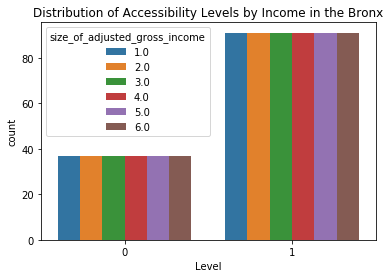

In [149]:
# How does this play out at a Borough specific level? Let's look at Manhattan and Bronx
bordf = df[df['Borough']=='X']
sns.countplot(x = 'Level', hue = 'size_of_adjusted_gross_income', data = bordf)
plt.title("Distribution of Accessibility Levels by Income in the Bronx")
plt.show()

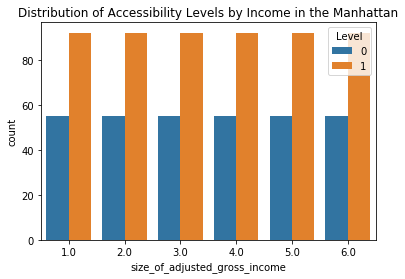

In [124]:
sns.countplot(x = 'size_of_adjusted_gross_income', hue = 'Level', data = bordf)
plt.title("Distribution of Accessibility Levels by Income in the Manhattan")
plt.show()

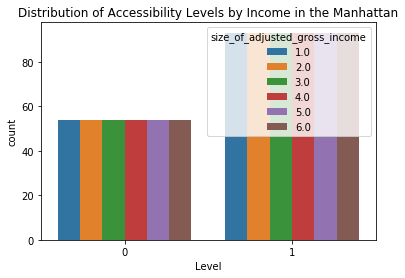

In [150]:
# How does this play out at a Borough specific level? Let's look at Manhattan and Bronx
bordf = df[df['Borough']=='M']
sns.countplot(x = 'Level', hue = 'size_of_adjusted_gross_income', data = bordf)
plt.title("Distribution of Accessibility Levels by Income in the Manhattan")
plt.show()

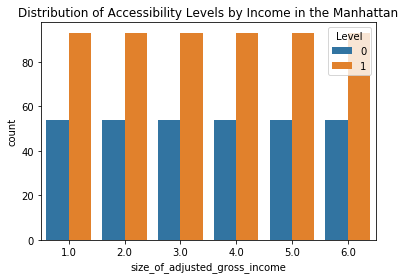

In [151]:
sns.countplot(x = 'size_of_adjusted_gross_income', hue = 'Level', data = bordf)
plt.title("Distribution of Accessibility Levels by Income in the Manhattan")
plt.show()

The second plot in each Borough category shows that the availability distribution of playgrounds is almost identical accross all income groups, suggesting that these variables are not strongly correlated

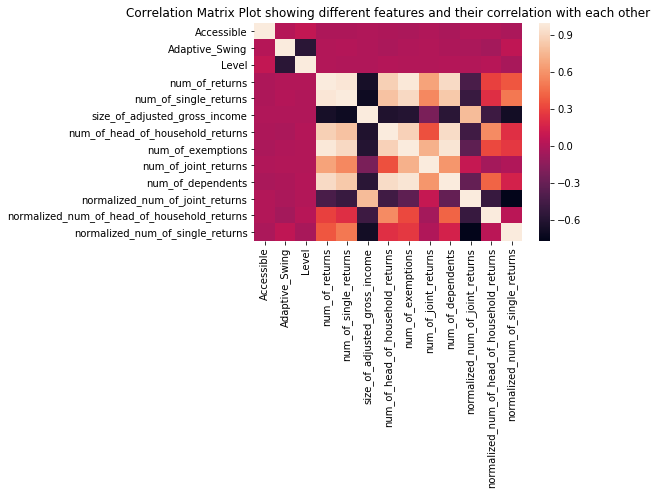

In [68]:
# Make a correlation plot to confirm. Convert the Level column to numeric
df['Level'] = df.Level.astype('float32')
sns.heatmap(df.corr())
plt.title('Correlation Matrix Plot showing different features and their correlation with each other')
plt.show()

In [69]:
df.corr().Level

Accessible                                     0.076418
Adaptive_Swing                                -0.572829
Level                                          1.000000
num_of_returns                                 0.004581
num_of_single_returns                         -0.000939
size_of_adjusted_gross_income                  0.000000
num_of_head_of_household_returns               0.014223
num_of_exemptions                              0.009715
num_of_joint_returns                           0.005316
num_of_dependents                              0.017000
normalized_num_of_joint_returns                0.010519
normalized_num_of_head_of_household_returns    0.029707
normalized_num_of_single_returns              -0.033173
Name: Level, dtype: float64

# Data Preprocessing

For further preparation of the data for ML, we need to drop some more columns:
1) We have subsumed the accessibility column under level, so we can drop that. Remember that anything that was not wheelchair accessible is classifed as Level 0 <br/>

2) The adaptive swing column is correlated to Level 0 -- Not accessible, and can help pick that out. <br/> 

3) We will only keep the normalized columns for joint, HOH and Single returns and drop the unnormalized ones. <br/>

4) We will keep the total number of returns column <br/> 

5) SInce the total returns is a pretty large number, we will standardize the columns as well <br/>


# Machine Learning modeling

Here we will try to predict the level of playground based on the data available.
For any ML model, we need to provide the label column first. Let's drop some of the fields above and prepare the data for ML training in SageMaker

In [70]:
final_df = df.drop(columns =['Accessible', 'num_of_returns', 
                             'num_of_dependents','num_of_joint_returns', 'num_of_head_of_household_returns',
                             'num_of_single_returns'])

In [71]:
final_df.shape

(4590, 8)

In [72]:
final_df = pd.get_dummies(final_df)
df1 = final_df.Level
df2 = final_df.drop(columns = 'Level')
final_df = pd.concat([df1, df2], axis = 1)
final_df.dropna(inplace=True)

In [73]:
final_df.shape

(4564, 13)

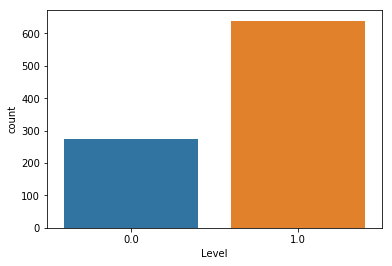

In [74]:
X_train, X_test = train_test_split(final_df, test_size = 0.2, random_state = 42)
sns.countplot(X_test.Level)

In [75]:
X_train.head()

,Level,Adaptive_Swing,size_of_adjusted_gross_income,num_of_exemptions,normalized_num_of_joint_returns,normalized_num_of_head_of_household_returns,normalized_num_of_single_returns,Borough_B,Borough_M,Borough_N,Borough_Q,Borough_R,Borough_X
3848,1.0,0.0,4.0,1620.0,0.111940,0.029851,0.820896,0,1,0,0,0,0
1207,1.0,0.0,1.0,19010.0,0.076699,0.344660,0.570874,0,0,0,0,0,1
5272,0.0,1.0,6.0,40.0,0.000000,0.000000,0.000000,0,0,0,0,0,1
241,1.0,0.0,3.0,7640.0,0.113379,0.371882,0.485261,1,0,0,0,0,0
993,1.0,0.0,5.0,3510.0,0.466216,0.297297,0.229730,0,0,0,1,0,0


In [102]:
X_train.isnull().any()


Level                                          False
Adaptive_Swing                                 False
size_of_adjusted_gross_income                  False
num_of_exemptions                              False
normalized_num_of_joint_returns                False
normalized_num_of_head_of_household_returns    False
normalized_num_of_single_returns               False
Borough_B                                      False
Borough_M                                      False
Borough_N                                      False
Borough_Q                                      False
Borough_R                                      False
Borough_X                                      False
dtype: bool

Upload Training data to S3

In [103]:
role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket() # you can replace with this your own bucket name
prefix = 'sagemaker/accessibility'

train_file = 'train.csv'
X_train.to_csv(train_file,index=False,header=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
train_data = sagemaker.session.s3_input('s3://{}/{}/train'.format(bucket, prefix), 
                                        content_type='csv')

In [104]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')


In [105]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))


training artifacts will be uploaded to: s3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/output


In [106]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': train_data, 'validation': train_data})

2019-12-23 19:06:32 Starting - Starting the training job...
2019-12-23 19:06:34 Starting - Launching requested ML instances......
2019-12-23 19:07:39 Starting - Preparing the instances for training......
2019-12-23 19:08:59 Downloading - Downloading input data
2019-12-23 19:08:59 Training - Downloading the training image...
2019-12-23 19:09:32 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:09:29] 3651x12 matrix with 43812 entries loaded from /opt/ml/input/data/train?format

# Using SageMaker Autopilot

As you can see, training an ML model, feature engineering, preprocessing can take quite some time and be a fairly involved process. Let's see how we can use SageMaker Autopilot, which is SageMaker's built in AutoML feature to take the raw dataset, and train a bunch of ML models, and let AutoPilot take care of the preprocessing, feature engineering and model training all within a few simple API calls. 

Lets start by looking at autodf -- we will drop the accessibility column, since we have already incorporated that into Level. Note that to go from autodf to the final training dataset for XGBoost above we had to implement a sequence of feature engineering steps:

1) We converted Borough columns to one hot encoding

2) We dropped all the non normalized columns which are strongly correlated with the feature engineered normalized ones.

3) We had to split the data randomly into training and test datasets which we uploaded separately to S3.

4) We had to save the csv files locally without headers and indexes. 

5) While this is not required for XGBoost, we removed missing values. Linear learner algorithm for example doesn't accept missing values. 

Autopilot takes care of all the feature engineering steps for us. Simply feed in the initial dataframe as an input, save it as csv, point Autopilot to the dependent variable and it will take care of the rest

In [88]:
#look at the autodf dataframe again
autodf.head()


,Accessible,Adaptive_Swing,Level,num_of_returns,num_of_single_returns,size_of_adjusted_gross_income,num_of_head_of_household_returns,num_of_exemptions,num_of_joint_returns,num_of_dependents,Borough
0,1.0,0.0,1,10120.0,6260.0,1.0,2310.0,16270.0,1380.0,5480.0,B
1,1.0,0.0,1,4890.0,2310.0,2.0,1510.0,9100.0,960.0,3260.0,B
2,1.0,0.0,1,2350.0,1050.0,3.0,580.0,4320.0,630.0,1350.0,B
3,1.0,0.0,1,1280.0,470.0,4.0,260.0,2490.0,520.0,700.0,B
4,1.0,0.0,1,1350.0,330.0,5.0,180.0,3100.0,810.0,950.0,B


In [89]:
# note that we have missing values in almost every column. We will drop those as AutoML doesn't support missing values
#for now.
autodf.isnull().any()

Accessible                           True
Adaptive_Swing                       True
Level                               False
num_of_returns                       True
num_of_single_returns                True
size_of_adjusted_gross_income        True
num_of_head_of_household_returns     True
num_of_exemptions                    True
num_of_joint_returns                 True
num_of_dependents                    True
Borough                             False
dtype: bool

In [90]:
#Load the autodf into s3 directly
autodf.dropna(inplace=True)
print(autodf.shape)
autodf = autodf.sample(frac=1)

#Let's take out a random sample for testing and set it aside
test_sample = autodf[TRAIN_LENGTH:]
print("Shape of test data = {}".format(test_sample.shape))
test_sample.drop(columns=['Accessible']).to_csv('automl-test.csv', index=False)


autodf[:TRAIN_LENGTH].drop(columns=['Accessible']).to_csv('automl-train.csv', index= False)
autotrainpath = session.upload_data(path="automl-train.csv", key_prefix=prefix + "/input")
print(autotrainpath)

(4590, 11)
Shape of test data = (459, 11)
s3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/input/automl-train.csv


In [91]:
# configure the AutoML job: specify the target attribute name and the location of the input file
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/input'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Level'
    
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/automloutput'.format(bucket,prefix)
  }
print(input_data_config)
print(output_data_config)

[{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/input'}}, 'TargetAttributeName': 'Level'}]
{'S3OutputPath': 's3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/automloutput'}


In [92]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

In [93]:
region = boto3.Session().region_name
sm = boto3.Session().client(service_name='sagemaker',region_name=region)
auto_ml_job_name = 'automl-dm-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      RoleArn=role,
                     ProblemType='BinaryClassification',
                     AutoMLJobObjective = {'MetricName':'Accuracy'})

AutoMLJobName: automl-dm-23-15-11-31


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:389535300735:automl-job/automl-dm-23-15-11-31',
 'ResponseMetadata': {'RequestId': 'df06c6c1-7c0e-4cd8-81d3-40ca486679ff',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'df06c6c1-7c0e-4cd8-81d3-40ca486679ff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '92',
   'date': 'Mon, 23 Dec 2019 15:11:41 GMT'},
  'RetryAttempts': 0}}

In [95]:
# Kick off the Autopilot job
import time
start = time.time()
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)
end = time.time()
print("Time Taken for job = {}".format(end - start))

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - 

In [96]:
describe_response

{'AutoMLJobName': 'automl-dm-23-15-11-31',
 'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:389535300735:automl-job/automl-dm-23-15-11-31',
 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 's3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/input'}},
   'TargetAttributeName': 'Level'}],
 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-east-1-389535300735/sagemaker/accessibility/automloutput'},
 'RoleArn': 'arn:aws:iam::389535300735:role/service-role/AmazonSageMaker-ExecutionRole-20190823T110499',
 'AutoMLJobObjective': {'MetricName': 'Accuracy'},
 'ProblemType': 'BinaryClassification',
 'CreationTime': datetime.datetime(2019, 12, 23, 15, 11, 41, 698000, tzinfo=tzlocal()),
 'EndTime': datetime.datetime(2019, 12, 23, 17, 11, 31, 899000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2019, 12, 23, 17, 11, 31, 936000, tzinfo=tzlocal()),
 'BestCandidate': {'CandidateName': 'tuning-job-1-e4229d391ccb4660b4-086-00948424',

In [97]:
# lets look at the best job
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))


{'CandidateName': 'tuning-job-1-e4229d391ccb4660b4-086-00948424', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:accuracy', 'Value': 0.8189550042152405}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:389535300735:processing-job/db-1-694f3608008c4db3b0ef60965eb5c9f476d3af96506144e49ff7d62b16', 'CandidateStepName': 'db-1-694f3608008c4db3b0ef60965eb5c9f476d3af96506144e49ff7d62b16'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:389535300735:training-job/automl-dm--dpp0-1-779b98a64b5c402bb77c98c96131c3e96841b2d538bc4', 'CandidateStepName': 'automl-dm--dpp0-1-779b98a64b5c402bb77c98c96131c3e96841b2d538bc4'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:389535300735:transform-job/automl-dm--dpp0-csv-1-b82f119579a84577a7b3c78d83c85030438f769d1', 'CandidateStepNa

In [98]:
# Let's now use boto3 to deploy the model
model_name = 'automl-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:us-east-1:389535300735:model/automl-23-15-11-31


In [99]:
endpoint_config_name = 'automl-endpoint-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

automl-endpoint-config2019-12-23-17-15-43
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:389535300735:endpoint-config/automl-endpoint-config2019-12-23-17-15-43


## Create the Endpoint for the AutoML job

In [100]:
%%time
import time

endpoint_name = 'autmlEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

autmlEndpoint-2019-12-23-17-15-48
arn:aws:sagemaker:us-east-1:389535300735:endpoint/autmlendpoint-2019-12-23-17-15-48
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:389535300735:endpoint/autmlendpoint-2019-12-23-17-15-48
Status: InService
CPU times: user 149 ms, sys: 10.5 ms, total: 159 ms
Wall time: 11min 1s


## Test the Model predictions

Replace the endpoint name below with your endpoint name from the above cell: it should start with 'autmlEndpoint-yyyy-mm-dd-hh-mm-ss'

In [120]:
from sagemaker.predictor import RealTimePredictor, csv_deserializer, csv_serializer
endpoint  = 'autmlEndpoint-2019-12-23-17-15-48' #replace with your endpoint name here
autopredictor = RealTimePredictor(endpoint = endpoint, serializer=csv_serializer, deserializer =csv_deserializer, 
                                  content_type='text/csv', sagemaker_session = session)

In [127]:
y_test = test_sample.Level
X_pred = test_sample.drop(columns = ['Level', 'Accessible']).reset_index().drop(columns = ['index'])
y_pred = [int(autopredictor.predict(np.array(X_pred.loc[x]))[0][0]) for x in range(len(X_pred))]

In [131]:
from sklearn.metrics import accuracy_score
print("Accuracy from AutoML Job = {}".format(accuracy_score(y_test, y_pred)))

Accuracy from AutoML Job = 0.8148148148148148


# Model Deployment

Here We explore two modes of model deployment -- batch and as a live inference endpoint. 
First we deploy as a live endpoint and obtain model metrics <br/>
Next we do a batch transform job. For this we need to load the test data into S3 as well <br/>

## Live Model Deployment

In [132]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------------------!

In [134]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

In [135]:
predictions = []
y_test = X_test.Level
X_test_drop = X_test.drop(columns = 'Level')
for i in range(X_test.shape[0]):
    predictions.append(xgb_predictor.predict(np.array(X_test_drop.iloc[i])))
predictions = np.array(np.round(predictions))

In [136]:
from sklearn.metrics import accuracy_score, auc, classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.51      0.65       274
         1.0       0.82      0.97      0.89       639

   micro avg       0.83      0.83      0.83       913
   macro avg       0.85      0.74      0.77       913
weighted avg       0.84      0.83      0.82       913



In [137]:
accuracy_score(y_test,predictions)

0.8324205914567361

Notice that the model where we have normalized the features returns a higher accuracy score, but the AutoML does a really good job without virtually any data preparation!

# Make Inferences directly in SQL using Amazon Athena

Next, we will ingest the training data csv file into Amazon Athena and perform inferences directly against the XGBoost SageMaker endpoint. Here we will show how the process works for the XGBoost endpoint. 

To do so, navigate to SageMaker console and go to Endpoints. Identify the endpoint you just created for XGBoost. It should start with 'sagemaker-xgboost-####'. 

## Delete Endpoints (Only do so after completing the Athena portion)

See the Readme in the Github for this workshop for next steps on how to complete invoke the model endpoints from Amazon Athena

In [ ]:
xgb_predictor.delete_endpoint()

In [ ]:
autopredictor.delete_endpoint()